## Santander product recommendation Analysis report



*@wirted by lazyer*

*@from 2018.12.26*

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [2]:
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'small'

In [3]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
colors_names = [name for hsv, name in by_hsv]


In [4]:
def reduce_mem_usage(props, fillna=False):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('[*]skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

## Data shape

In [28]:
#Data size
trn = pd.read_csv('data/train_ver2.csv')
trn, NAlist = reduce_mem_usage(trn)
print(trn.shape)

Memory usage of properties dataframe is : 4997.793899536133  MB
******************************
Column:  ncodpers
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  ind_nuevo
dtype before:  float64
[*]skip ind_nuevo cause of NA value
******************************
Column:  indrel
dtype before:  float64
[*]skip indrel cause of NA value
******************************
Column:  tipodom
dtype before:  float64
[*]skip tipodom cause of NA value
******************************
Column:  cod_prov
dtype before:  float64
[*]skip cod_prov cause of NA value
******************************
Column:  ind_actividad_cliente
dtype before:  float64
[*]skip ind_actividad_cliente cause of NA value
******************************
Column:  renta
dtype before:  float64
[*]skip renta cause of NA value
******************************
Column:  ind_ahor_fin_ult1
dtype before:  int64
dtype after:  uint8
******************************
**************************

## Data Type

In [7]:
print(trn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
fecha_dato               object
ncodpers                 uint32
ind_empleado             object
pais_residencia          object
sexo                     object
age                      object
fecha_alta               object
ind_nuevo                float64
antiguedad               object
indrel                   float64
ult_fec_cli_1t           object
indrel_1mes              object
tiprel_1mes              object
indresi                  object
indext                   object
conyuemp                 object
canal_entrada            object
indfall                  object
tipodom                  float64
cod_prov                 float64
nomprov                  object
ind_actividad_cliente    float64
renta                    float64
segmento                 object
ind_ahor_fin_ult1        uint8
ind_aval_fin_ult1        uint8
ind_cco_fin_ult1         uint8
ind_cder_fin_ult1 

In [8]:
#Check Data head
for col in trn.columns:
    print('{}\n'.format(trn[col].head()))

0    2015-01-28
1    2015-01-28
2    2015-01-28
3    2015-01-28
4    2015-01-28
Name: fecha_dato, dtype: object

0    1375586
1    1050611
2    1050612
3    1050613
4    1050614
Name: ncodpers, dtype: uint32

0    N
1    N
2    N
3    N
4    N
Name: ind_empleado, dtype: object

0    ES
1    ES
2    ES
3    ES
4    ES
Name: pais_residencia, dtype: object

0    H
1    V
2    V
3    H
4    V
Name: sexo, dtype: object

0     35
1     23
2     23
3     22
4     23
Name: age, dtype: object

0    2015-01-12
1    2012-08-10
2    2012-08-10
3    2012-08-10
4    2012-08-10
Name: fecha_alta, dtype: object

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: ind_nuevo, dtype: float64

0          6
1         35
2         35
3         35
4         35
Name: antiguedad, dtype: object

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: indrel, dtype: float64

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: ult_fec_cli_1t, dtype: object

0    1
1    1
2    1
3    1
4    1
Name: indrel_1mes, dtype: obj

## Data describe

In [9]:
#Valuable columns
num_cols = [col for col in trn.columns[:24] 
                        if trn[col].dtype in ['int64', 'float64']]
num_desc = trn[num_cols].describe()
num_desc

,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta
count,1.361958e+07,1.361958e+07,13619574.0,1.355372e+07,1.361958e+07,1.085293e+07
mean,5.956184e-02,1.178399e+00,1.0,2.657147e+01,4.578105e-01,1.342543e+05
std,2.366733e-01,4.177469e+00,0.0,1.278402e+01,4.982169e-01,2.306202e+05
min,0.000000e+00,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03
25%,0.000000e+00,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.871098e+04
50%,0.000000e+00,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.018500e+05
75%,0.000000e+00,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.559560e+05
max,1.000000e+00,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07


In [11]:
#Valuable columns
num_cols = [col for col in trn.columns[:24] 
                        if trn[col].dtype in ['uint8', 'uint32', 'float32']]
num_desc = trn[num_cols].describe()
num_desc

,ncodpers
count,1.364731e+07
mean,8.349042e+05
std,4.315650e+05
min,1.588900e+04
25%,4.528130e+05
50%,9.318930e+05
75%,1.199286e+06
max,1.553689e+06


In [12]:
for col in num_cols:
    print("[{:22}]'s count : {}%".format(
                           col, num_desc[col]['count']/trn.shape[0]*100))

[ncodpers              ]'s count : 100.0%


In [13]:
#Categorial columns
cat_cols = [col for col in trn.columns[:24]
                        if trn[col].dtype in ['O']]
cat_desc = trn[cat_cols].describe()
cat_desc

,fecha_dato,ind_empleado,pais_residencia,sexo,age,fecha_alta,antiguedad,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,segmento
count,13647309,13619575,13619575,13619505,13647309,13619575,13647309,24793,13497528.0,13497528,13619575,13619575,1808,13461183,13619575,13553718,13457941
unique,17,5,118,2,235,6756,507,223,13.0,5,2,2,2,162,2,52,3
top,2016-05-28,N,ES,V,23,2014-07-28,0,2015-12-24,1.0,I,S,N,N,KHE,N,MADRID,02 - PARTICULARES
freq,931453,13610977,13553710,7424252,542682,57389,134335,763,7277607.0,7304875,13553711,12974839,1791,4055270,13584813,4409600,7960220


In [14]:
for col in cat_cols:
    print("[{:15}]'s count : {}%".format(
                             col,cat_desc[col]['count']/trn.shape[0]*100))

[fecha_dato     ]'s count : 100.0%
[ind_empleado   ]'s count : 99.7967804495377%
[pais_residencia]'s count : 99.7967804495377%
[sexo           ]'s count : 99.79626752790605%
[age            ]'s count : 100.0%
[fecha_alta     ]'s count : 99.7967804495377%
[antiguedad     ]'s count : 100.0%
[ult_fec_cli_1t ]'s count : 0.18166951448084015%
[indrel_1mes    ]'s count : 98.90248692984089%
[tiprel_1mes    ]'s count : 98.90248692984089%
[indresi        ]'s count : 99.7967804495377%
[indext         ]'s count : 99.7967804495377%
[conyuemp       ]'s count : 0.013248033000498488%
[canal_entrada  ]'s count : 98.63617069123298%
[indfall        ]'s count : 99.7967804495377%
[nomprov        ]'s count : 99.31421645102341%
[segmento       ]'s count : 98.6124150922354%


In [15]:
for col in cat_cols:
    print("[{:15}]'s freq/count : {}%".format(
                  col, cat_desc[col]['freq']/cat_desc[col]['count']*100))

[fecha_dato     ]'s freq/count : 6.825177036733029%
[ind_empleado   ]'s freq/count : 99.93687027678911%
[pais_residencia]'s freq/count : 99.51639460115312%
[sexo           ]'s freq/count : 54.511907738203405%
[age            ]'s freq/count : 3.9764762415799333%
[fecha_alta     ]'s freq/count : 0.42137144514421343%
[antiguedad     ]'s freq/count : 0.9843332484081659%
[ult_fec_cli_1t ]'s freq/count : 3.0774815472109065%
[indrel_1mes    ]'s freq/count : 53.91807299825568%
[tiprel_1mes    ]'s freq/count : 54.12009517594629%
[indresi        ]'s freq/count : 99.51640194352613%
[indext         ]'s freq/count : 95.26610778970709%
[conyuemp       ]'s freq/count : 99.05973451327434%
[canal_entrada  ]'s freq/count : 30.125658346669827%
[indfall        ]'s freq/count : 99.74476442913968%
[nomprov        ]'s freq/count : 32.53424632266954%
[segmento       ]'s freq/count : 59.1488698011085%


## Fill Data or trash

--------------------------------------------------
col : fecha_dato


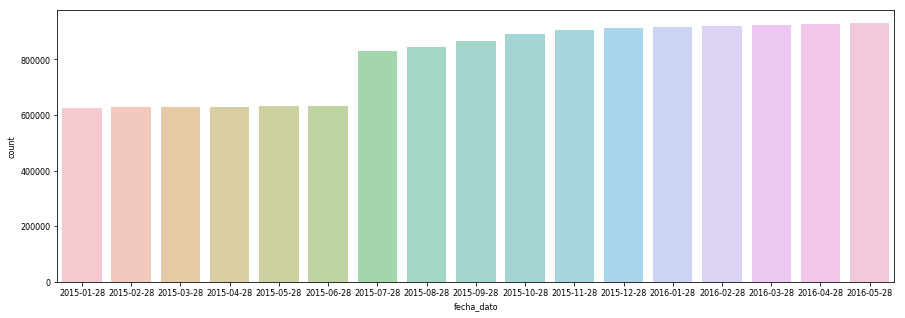

--------------------------------------------------
col : ind_empleado


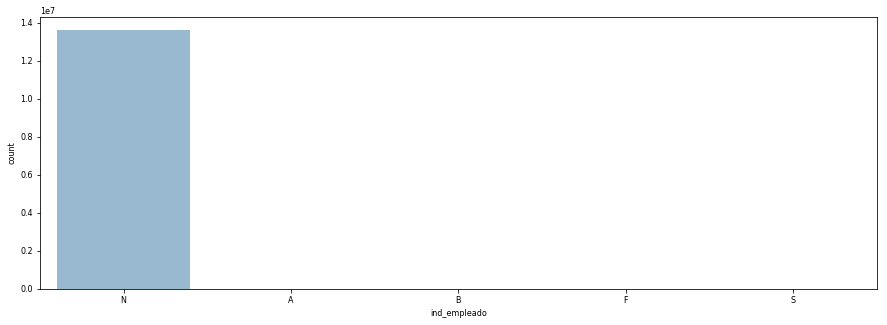

--------------------------------------------------
col : pais_residencia


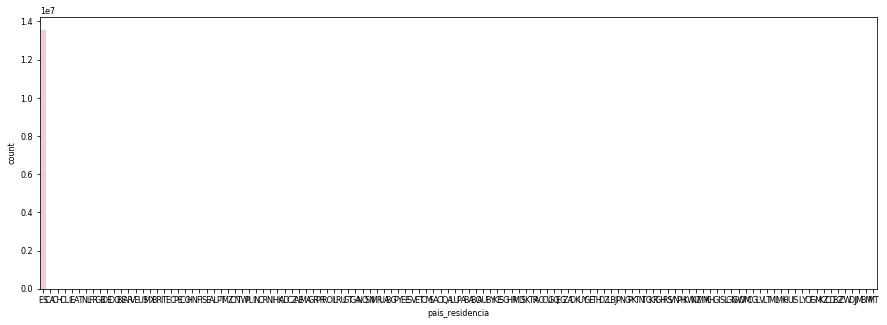

--------------------------------------------------
col : sexo


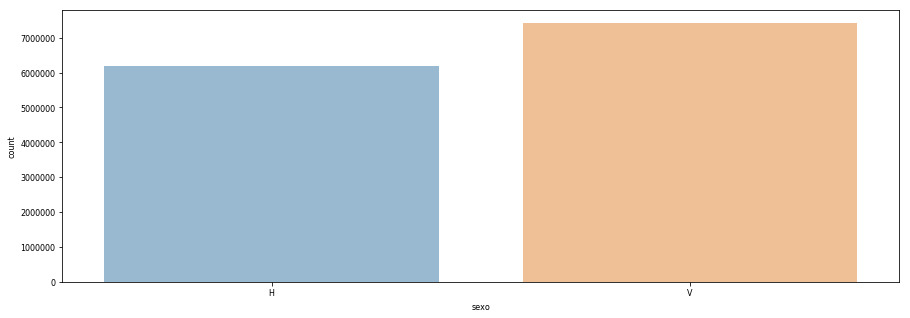

--------------------------------------------------
col : age


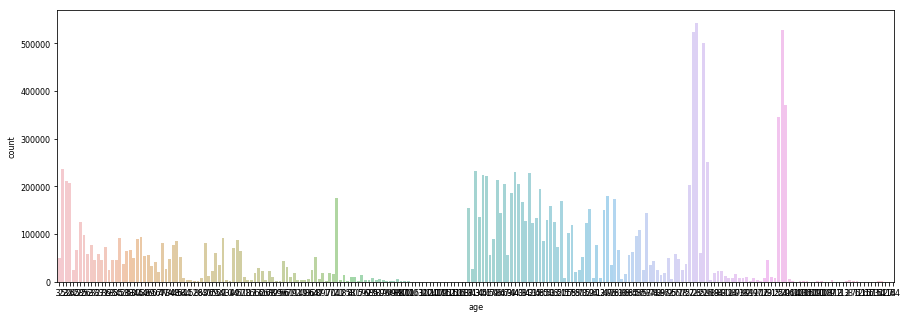

--------------------------------------------------
col : fecha_alta


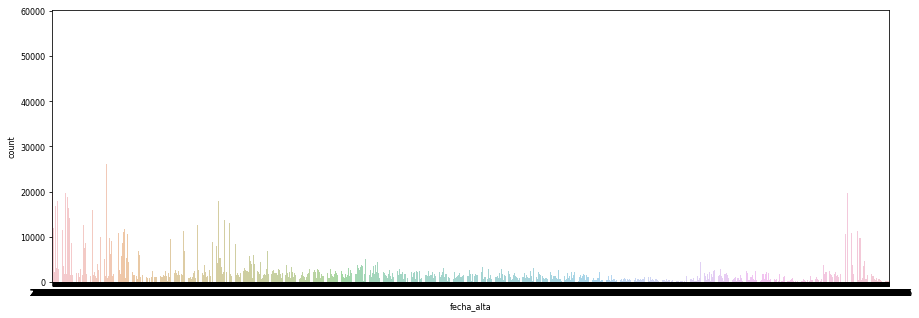

--------------------------------------------------
col : ind_nuevo


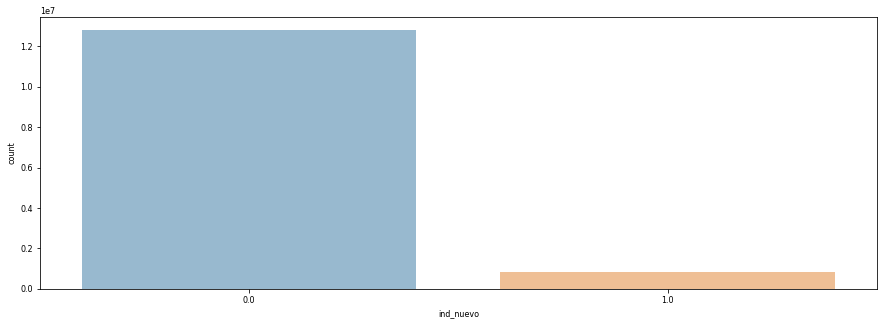

--------------------------------------------------
col : antiguedad


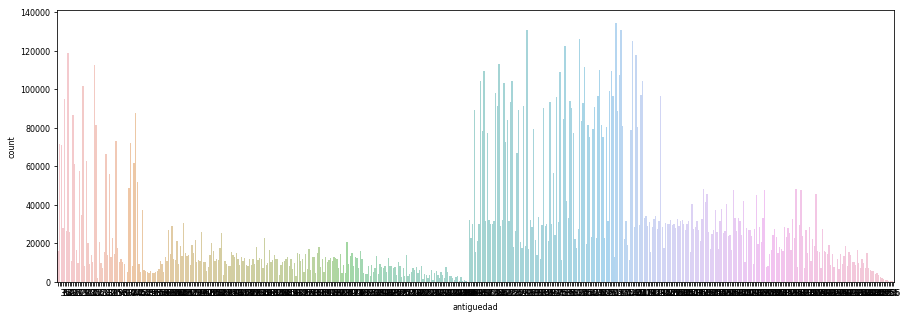

--------------------------------------------------
col : indrel


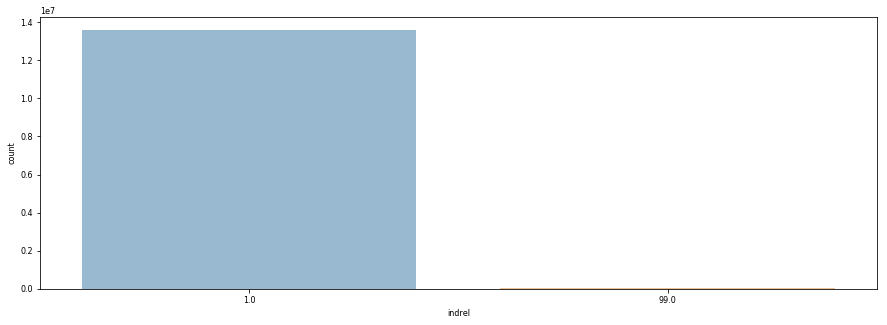

--------------------------------------------------
col : ult_fec_cli_1t


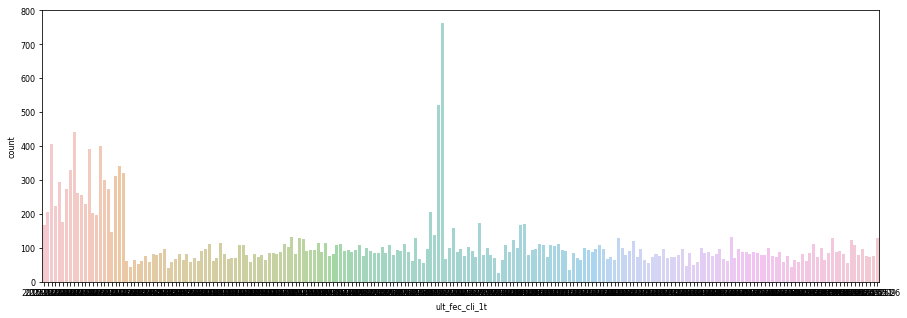

--------------------------------------------------
col : indrel_1mes


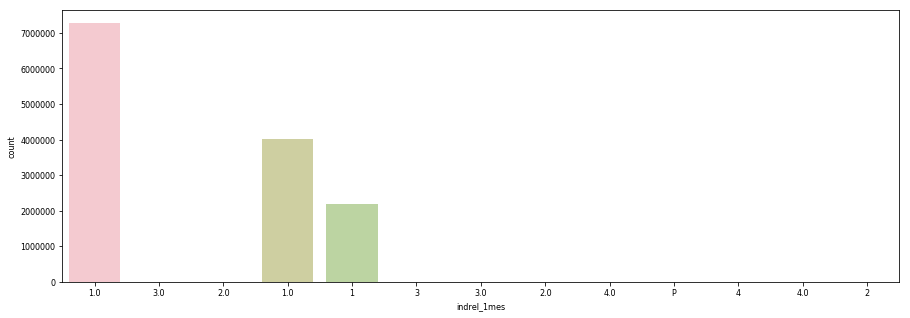

--------------------------------------------------
col : tiprel_1mes


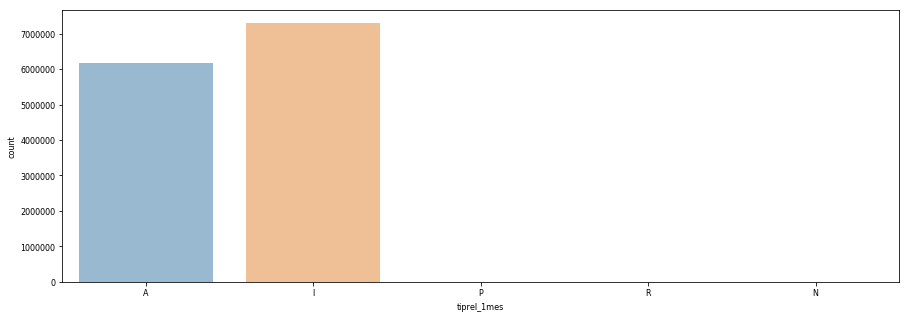

--------------------------------------------------
col : indresi


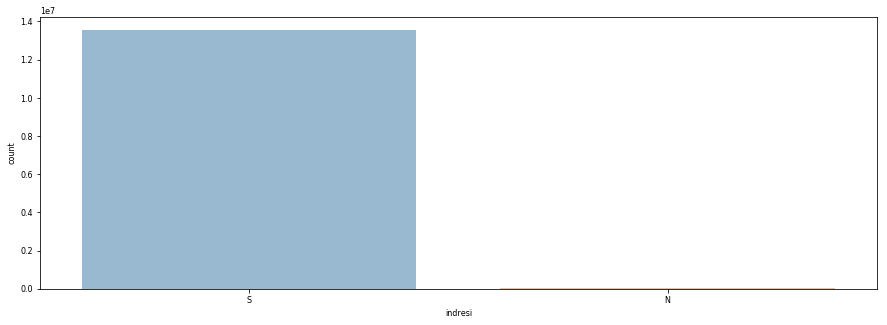

--------------------------------------------------
col : indext


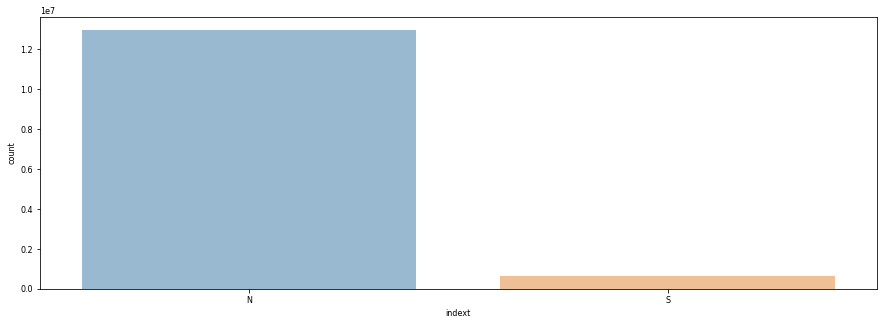

--------------------------------------------------
col : conyuemp


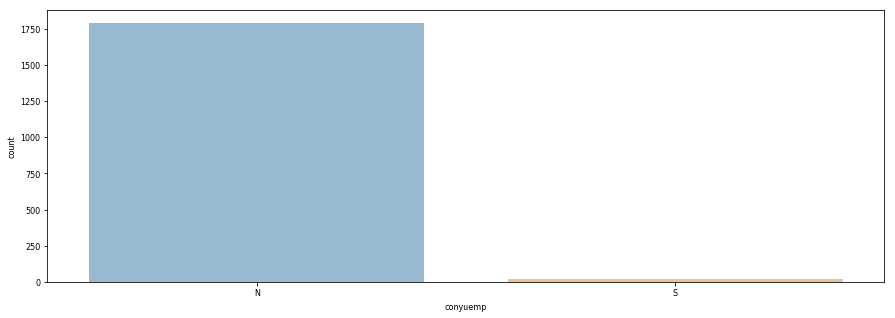

--------------------------------------------------
col : canal_entrada


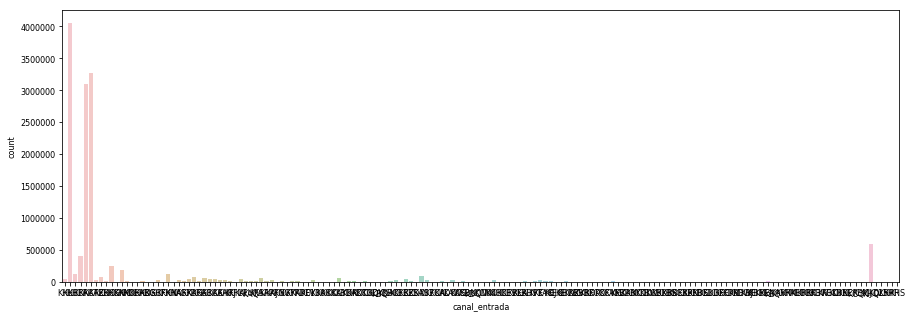

--------------------------------------------------
col : indfall


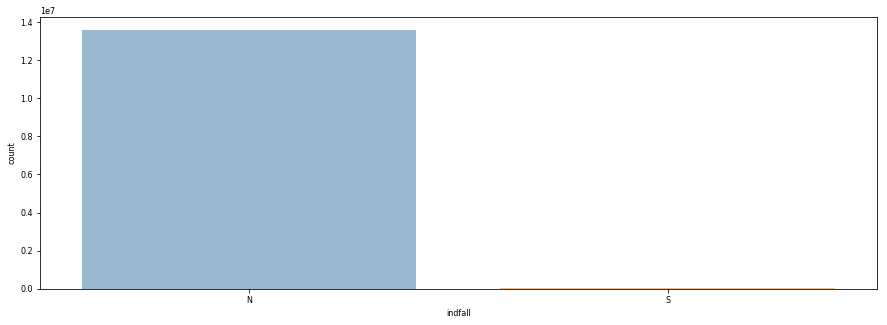

--------------------------------------------------
col : tipodom


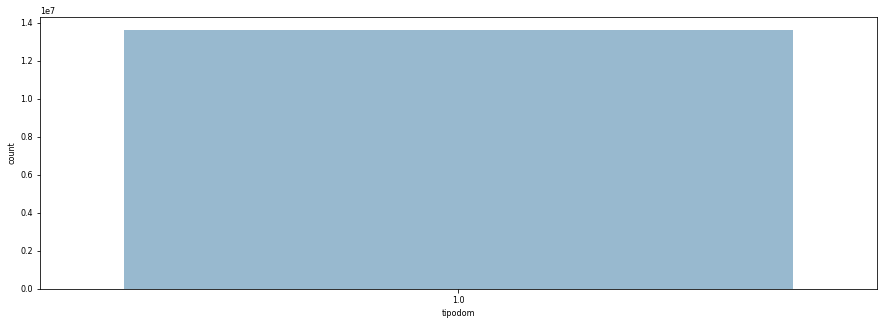

--------------------------------------------------
col : cod_prov


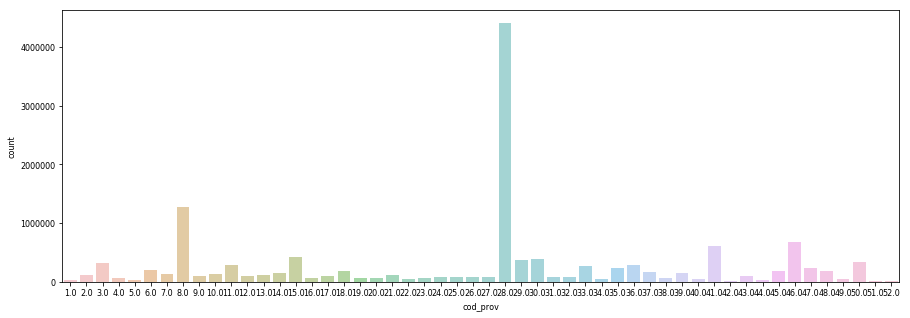

--------------------------------------------------
col : nomprov


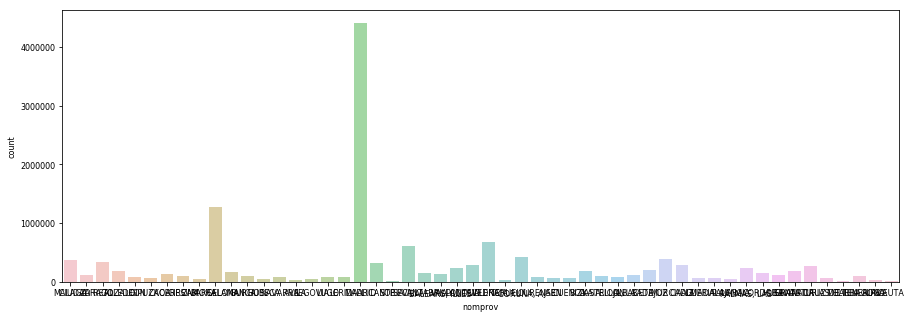

--------------------------------------------------
col : ind_actividad_cliente


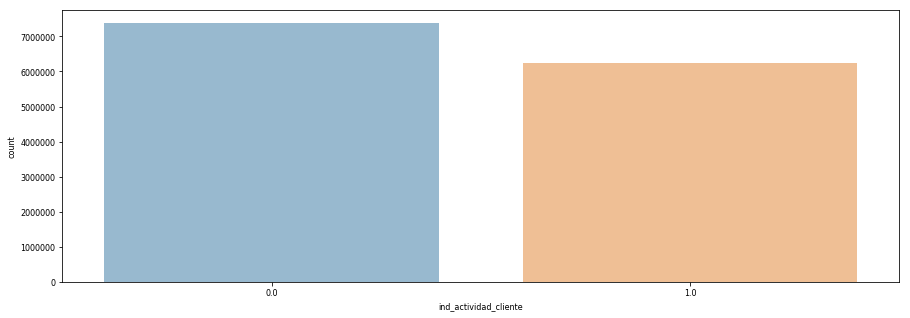

--------------------------------------------------
col : segmento


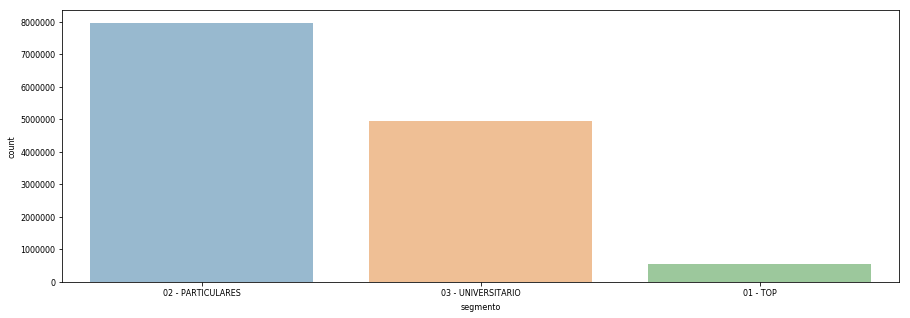

--------------------------------------------------
col : ind_ahor_fin_ult1


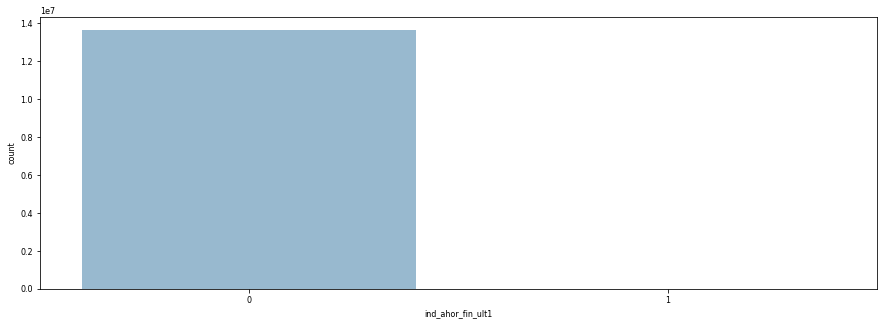

--------------------------------------------------
col : ind_aval_fin_ult1


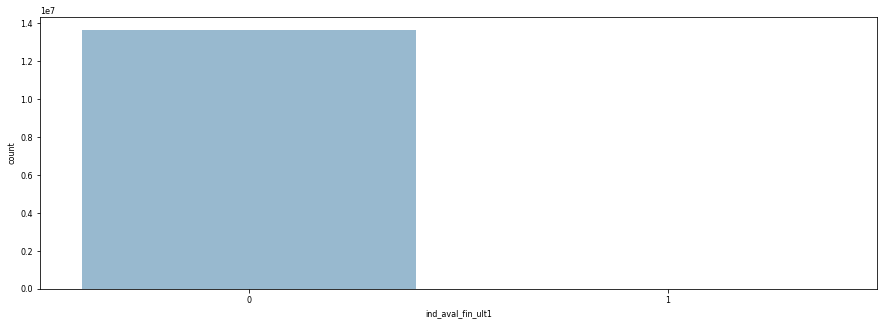

--------------------------------------------------
col : ind_cco_fin_ult1


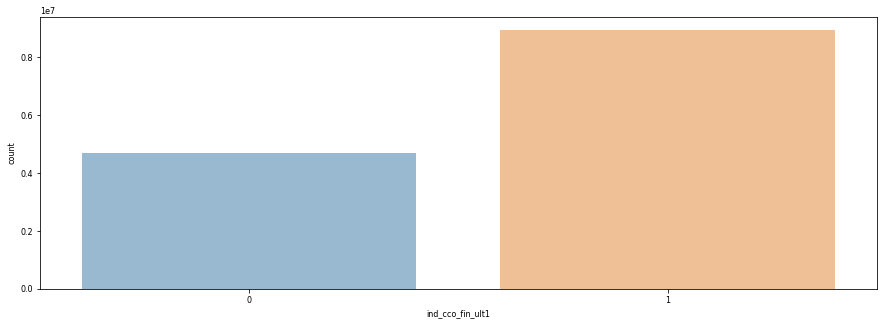

--------------------------------------------------
col : ind_cder_fin_ult1


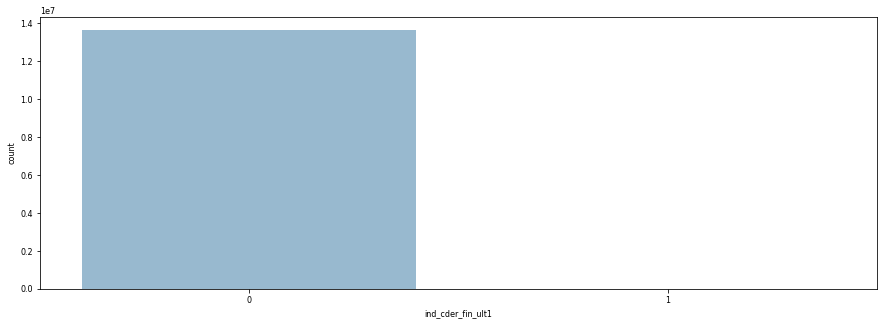

--------------------------------------------------
col : ind_cno_fin_ult1


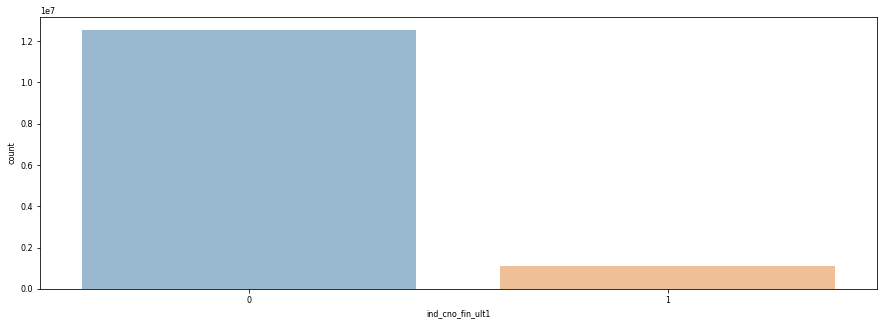

--------------------------------------------------
col : ind_ctju_fin_ult1


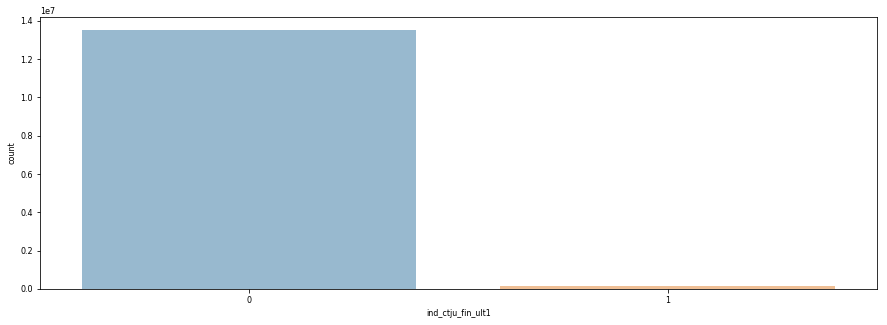

--------------------------------------------------
col : ind_ctma_fin_ult1


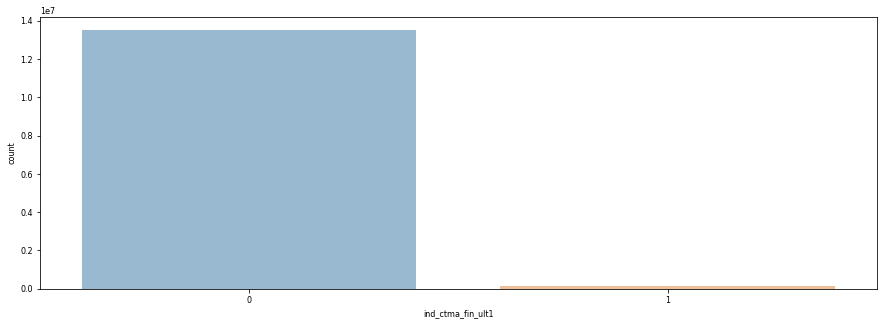

--------------------------------------------------
col : ind_ctop_fin_ult1


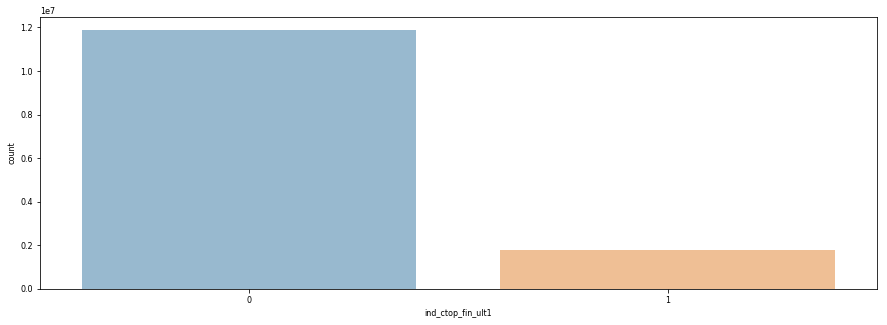

--------------------------------------------------
col : ind_ctpp_fin_ult1


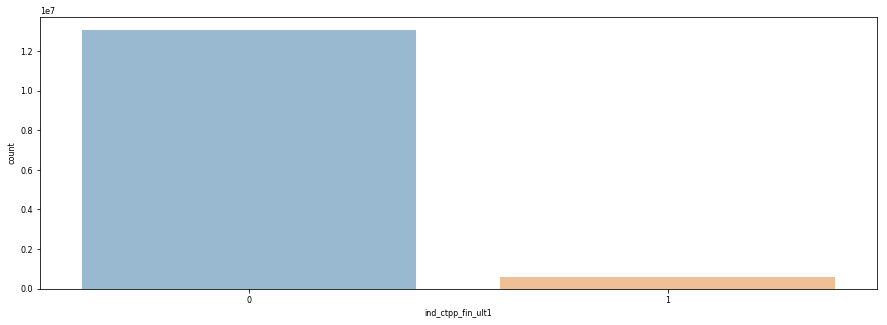

--------------------------------------------------
col : ind_deco_fin_ult1


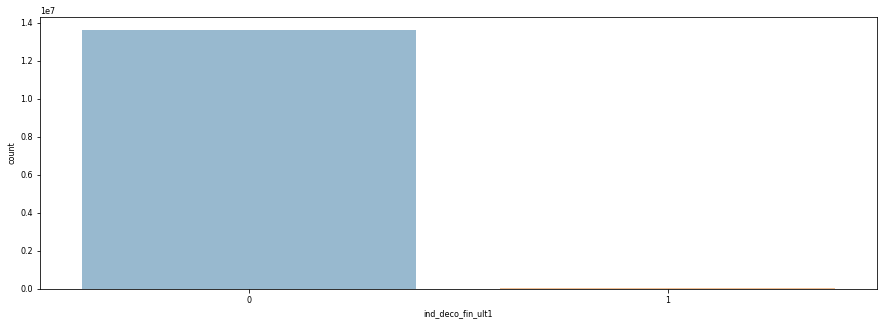

--------------------------------------------------
col : ind_deme_fin_ult1


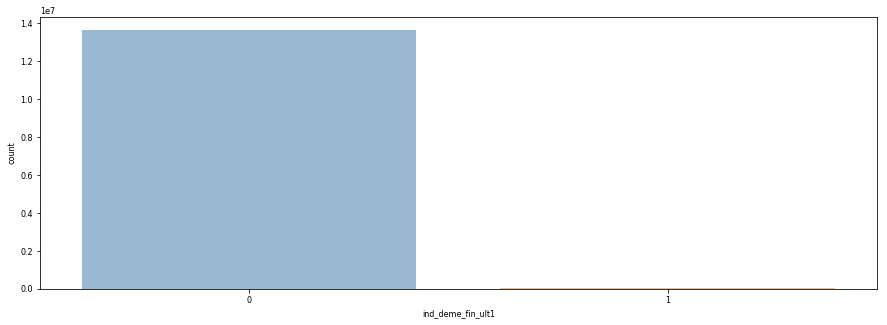

--------------------------------------------------
col : ind_dela_fin_ult1


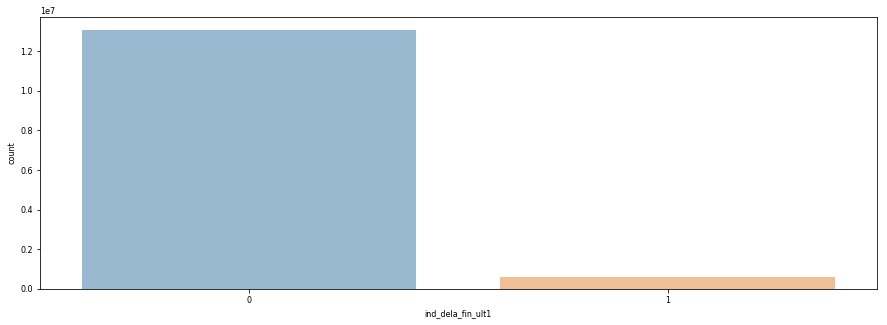

--------------------------------------------------
col : ind_ecue_fin_ult1


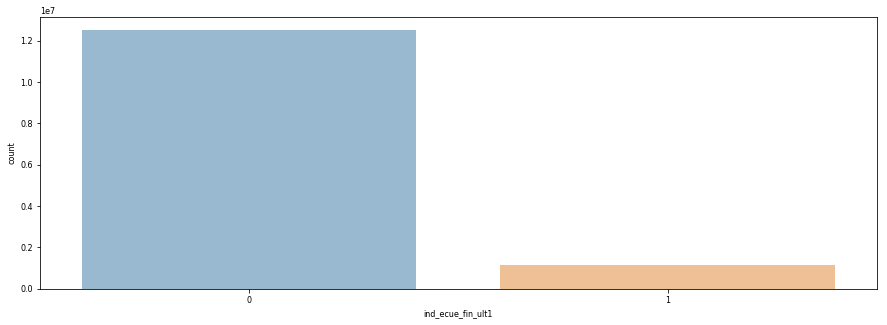

--------------------------------------------------
col : ind_fond_fin_ult1


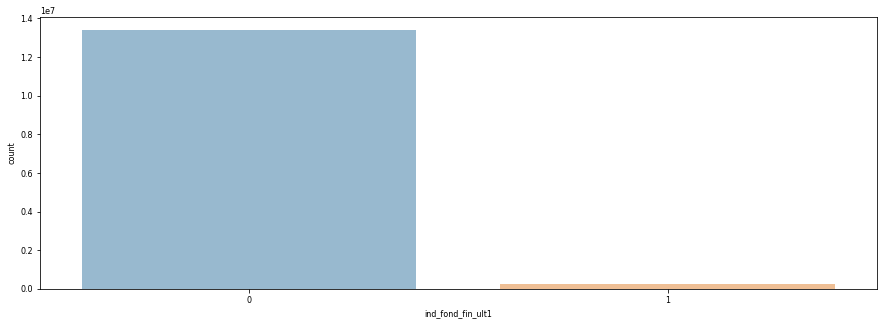

--------------------------------------------------
col : ind_hip_fin_ult1


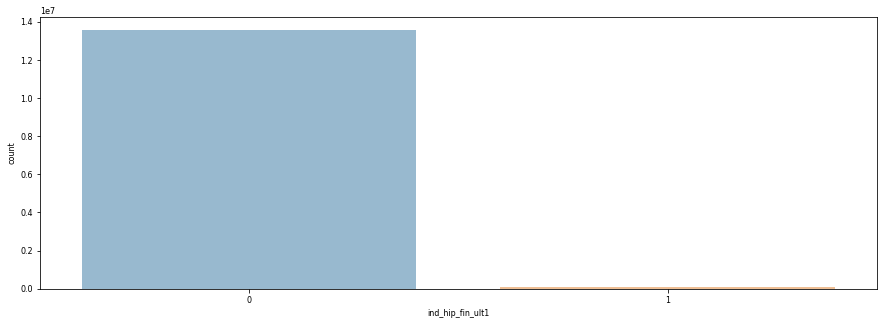

--------------------------------------------------
col : ind_plan_fin_ult1


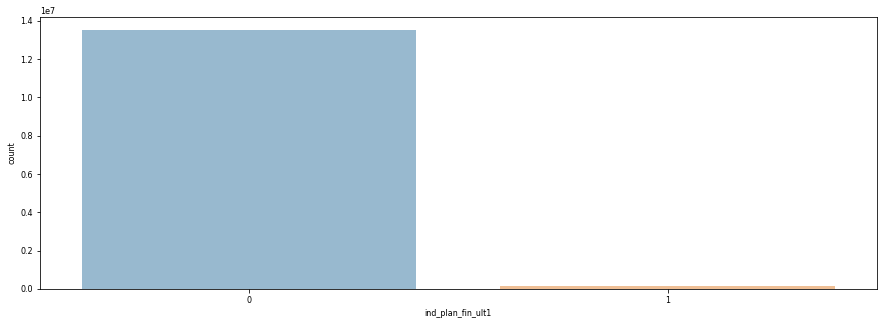

--------------------------------------------------
col : ind_pres_fin_ult1


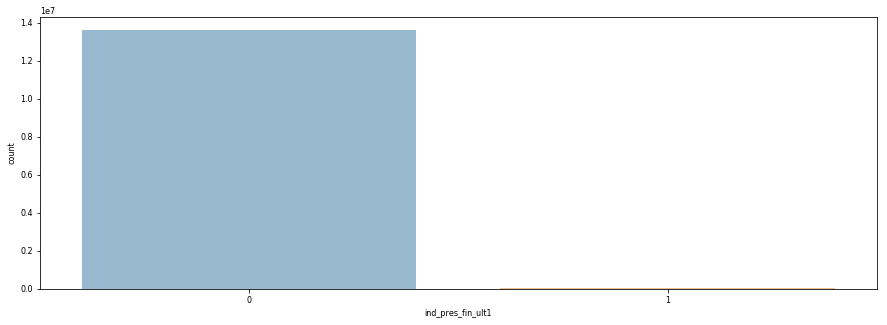

--------------------------------------------------
col : ind_reca_fin_ult1


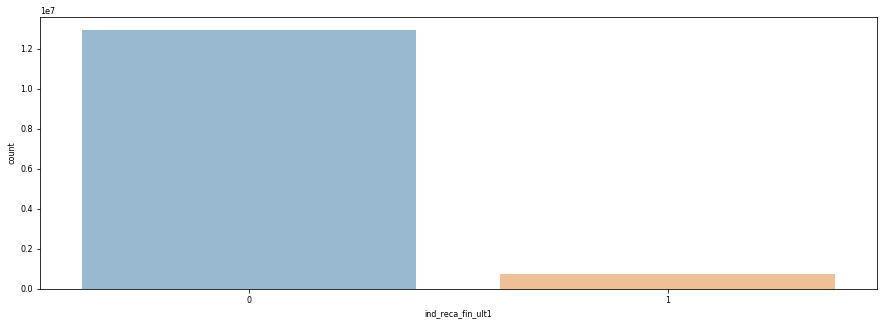

--------------------------------------------------
col : ind_tjcr_fin_ult1


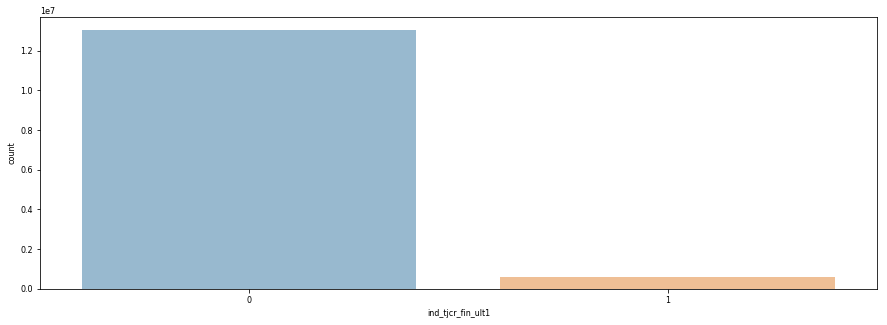

--------------------------------------------------
col : ind_valo_fin_ult1


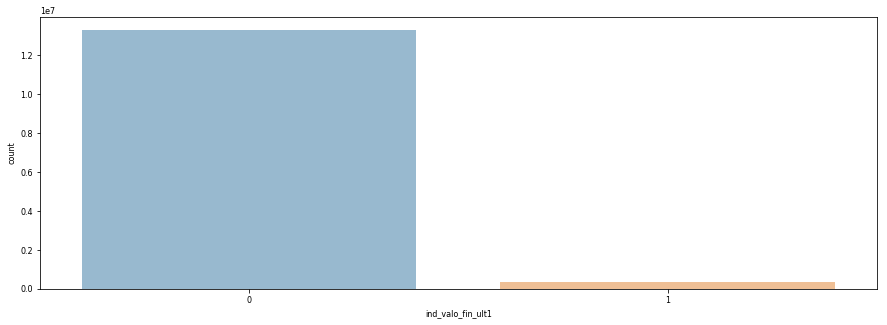

--------------------------------------------------
col : ind_viv_fin_ult1


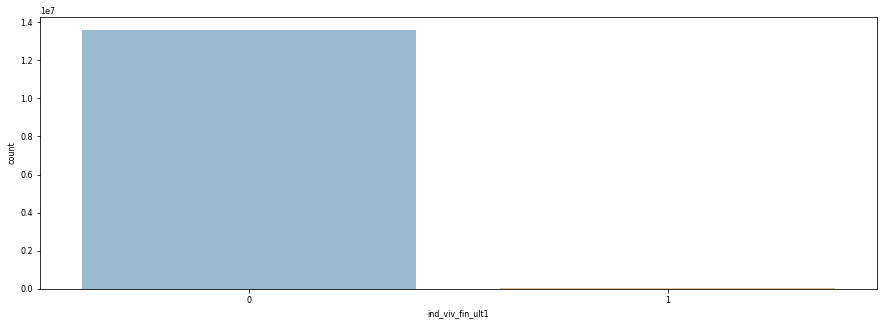

--------------------------------------------------
col : ind_nomina_ult1


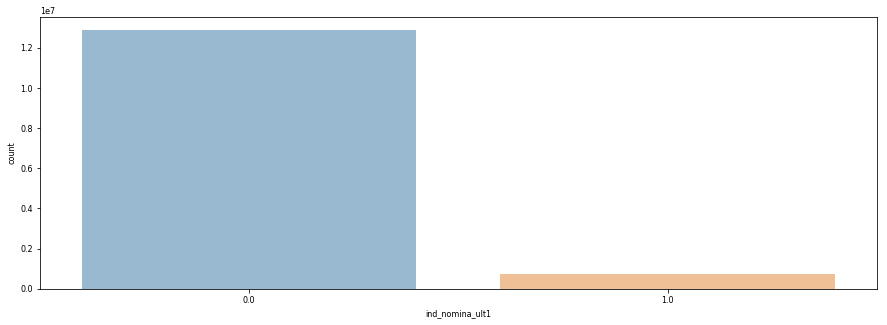

--------------------------------------------------
col : ind_nom_pens_ult1


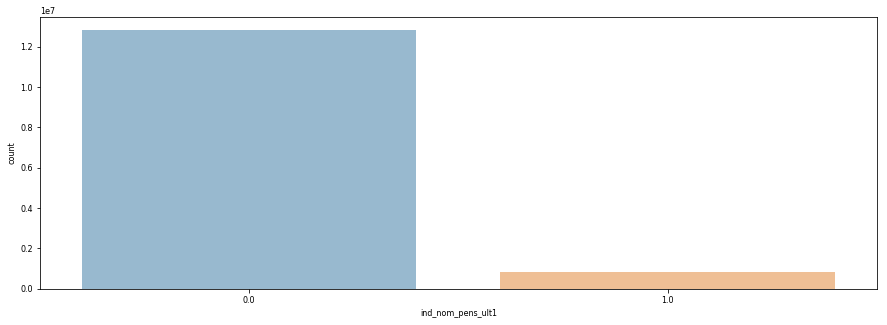

--------------------------------------------------
col : ind_recibo_ult1


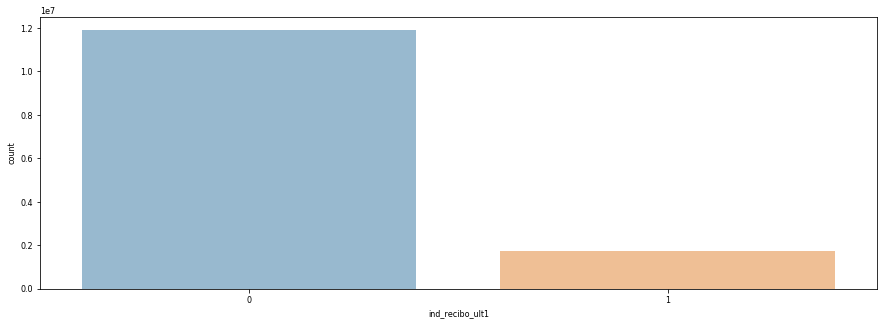

In [16]:
skip_cols = ['ncodpers', 'renta']
for col in trn.columns:
    if col in skip_cols:
        continue
    print('-'*50)
    print('col : {}'.format(col))
    
    f, ax = plt.subplots(figsize=(15,5))
    sns.countplot(x=col, data=trn, alpha=0.5)
    plt.show()

Visualize sum of posess product by month

In [17]:
months = trn['fecha_dato'].unique().tolist()
labels_cols = trn.columns[24:].tolist()
print('>>>months\n{}'.format(months))
print()
print('>>>labels_cols\n{}'.format(labels_cols))

>>>months
['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28', '2015-06-28', '2015-07-28', '2015-08-28', '2015-09-28', '2015-10-28', '2015-11-28', '2015-12-28', '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28']

>>>labels_cols
['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']


In [18]:
label_over_time = []
for i in range(len(labels_cols)):
    label_sum = trn.groupby(['fecha_dato'])[labels_cols[i]].agg('sum')
    label_over_time.append(list(map(int, label_sum.tolist())))

label_sum_over_time = []
for i in range(len(labels_cols)):
    label_sum_over_time.append(np.asarray(label_over_time[i:]).sum(axis=0))

label_sum_percent = (label_sum_over_time / 
                     (1. * np.asarray(label_sum_over_time).max(axis=0)))*100


check amount of Financial asset holdings

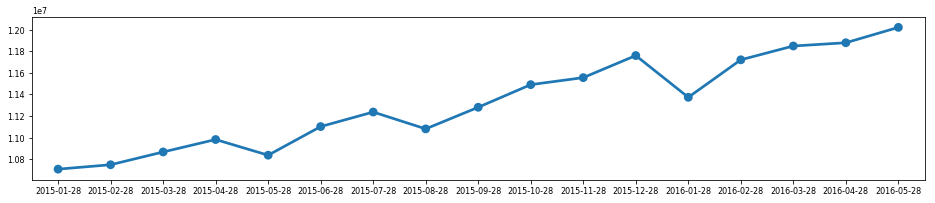

In [19]:
f, ax = plt.subplots(figsize=(16,3))
sns.pointplot(x=months, y = np.asarray(label_sum_over_time).sum(axis=0))

check percentage of Financial asset holdings through time

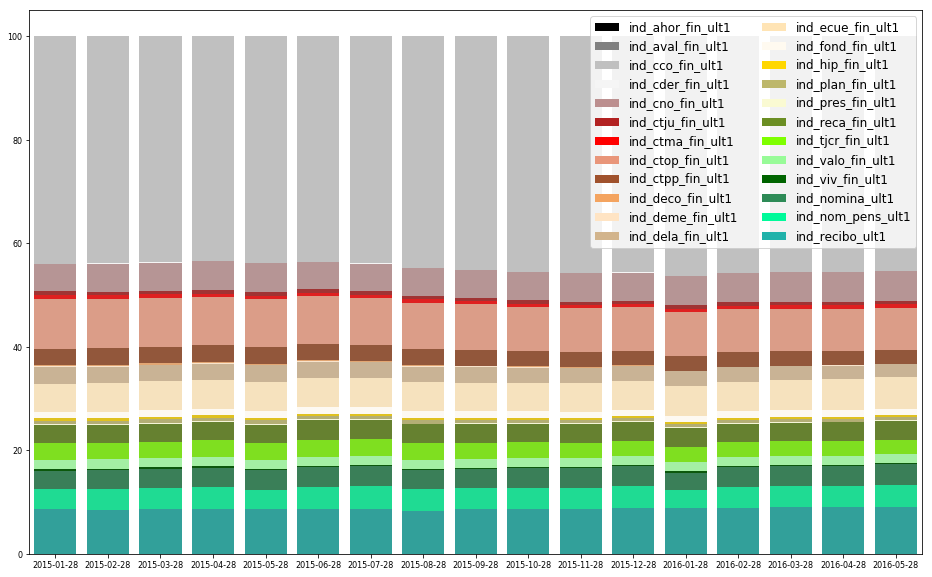

In [20]:
f, ax = plt.subplots(figsize=(16,10))
for i in range(len(labels_cols)):
    sns.barplot(x=months, y=label_sum_percent[i], 
                color=colors_names[(i*4)%len(colors_names)])

plt.legend([plt.Rectangle((0,0), 1, 1, 
                          fc=colors_names[(i*4)%len(colors_names)], 
                          edgecolor='none') 
                          for i in range(len(labels_cols))],
                          labels_cols, loc=1, ncol=2, prop={'size':12})

check 'new contract' through time

In [13]:
#Data size
trn = pd.read_csv('data/train_ver2.csv')
trn, NAlist = reduce_mem_usage(trn)
print(trn.shape)

Memory usage of properties dataframe is : 4997.793899536133  MB
******************************
Column:  ncodpers
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  ind_nuevo
dtype before:  float64
[*]skip ind_nuevo cause of NA value
******************************
Column:  indrel
dtype before:  float64
[*]skip indrel cause of NA value
******************************
Column:  tipodom
dtype before:  float64
[*]skip tipodom cause of NA value
******************************
Column:  cod_prov
dtype before:  float64
[*]skip cod_prov cause of NA value
******************************
Column:  ind_actividad_cliente
dtype before:  float64
[*]skip ind_actividad_cliente cause of NA value
******************************
Column:  renta
dtype before:  float64
[*]skip renta cause of NA value
******************************
Column:  ind_ahor_fin_ult1
dtype before:  int64
dtype after:  uint8
******************************
**************************

In [14]:
prods = trn.columns[24:].tolist()
needless_cols = trn.columns[2:24].tolist()
trn = trn.drop(needless_cols, axis=1)

In [15]:
def date_to_int(str_date):
    Y, M, D = [int(a) for a in str_date.strip().split("-")]
    int_date = (int(Y) - 2015) * 12 + int(M)
    return int_date
trn['int_date'] = trn['fecha_dato'].map(date_to_int).astype(np.int8)#type(trn['fecha_data']) = pandas.Series
trn = trn.drop(['fecha_dato'], axis=1)

In [16]:
standard_cols = ['int_date', 'ncodpers']
df_trn = trn[standard_cols+prods].copy()

for prod in prods:
    print('[*]process {}...'.format(prod))
    trn_leg = standard_cols + [prod]
    trn_bk = trn[trn_leg].copy()
    trn_bk['int_date'] += 1
    trn_bk.columns = [col+'_prev' if col == prod else col 
                      for col in trn_leg]
    df_trn = df_trn.merge(trn_bk, on=['int_date', 'ncodpers'], how='left')
    trn.drop([prod], axis=1)

[*]process ind_ahor_fin_ult1...
['int_date', 'ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1', 'ind_ahor_fin_ult1_prev']
[*]process ind_aval_fin_ult1...
['int_date', 'ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_

['int_date', 'ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1', 'ind_ahor_fin_ult1_prev', 'ind_aval_fin_ult1_prev', 'ind_cco_fin_ult1_prev', 'ind_cder_fin_ult1_prev', 'ind_cno_fin_ult1_prev', 'ind_ctju_fin_ult1_prev', 'ind_ctma_fin_ult1_prev', 'ind_ctop_fin_ult1_prev', 'ind_ctpp_fin_ult1_prev', 'ind_deco_fin_ult1_prev', 'ind_deme_fin_ult1_prev', 'ind_dela_fin_ult1_prev', 'ind_ecue_fin_ult1_prev']
[*]process ind_fond_fin_ult1...
['int_date', 'ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'in

['int_date', 'ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1', 'ind_ahor_fin_ult1_prev', 'ind_aval_fin_ult1_prev', 'ind_cco_fin_ult1_prev', 'ind_cder_fin_ult1_prev', 'ind_cno_fin_ult1_prev', 'ind_ctju_fin_ult1_prev', 'ind_ctma_fin_ult1_prev', 'ind_ctop_fin_ult1_prev', 'ind_ctpp_fin_ult1_prev', 'ind_deco_fin_ult1_prev', 'ind_deme_fin_ult1_prev', 'ind_dela_fin_ult1_prev', 'ind_ecue_fin_ult1_prev', 'ind_fond_fin_ult1_prev', 'ind_hip_fin_ult1_prev', 'ind_plan_fin_ult1_prev', 'ind_pres_fin_ult1_prev', 'ind_reca_fin_ult1_prev', 'ind_tjcr_fin_

In [17]:
for prod in prods:
    prev = prod+'_prev'
    df_trn[prev].fillna(0, inplace=True)

In [18]:
for prod in prods:
    padd = prod + '_add'
    prev = prod + '_prev'
    df_trn[padd] = ((df_trn[prod]==1) & (df_trn[prev] == 0)).astype(np.int8)

In [20]:
add_cols = [prod + '_add' for prod in prods]
labels_bk = df_trn[add_cols].columns
df_trn[add_cols].columns = prods
df_trn[add_cols].to_csv('data/labels.csv', index=False)
df_trn[add_cols].columns = labels_bk

In [23]:
%reset
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), 
                 name)
                for name, color in colors.items())
colors_names = [name for hsv, name in by_hsv]

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [26]:
labels = pd.read_csv('data/labels.csv').astype(int)
fecha_dato = pd.read_csv('data/train_ver2.csv', usecols=['fecha_dato'])

In [30]:
labels['date'] = fecha_dato.fecha_dato
months = np.unique(fecha_dato.fecha_dato).tolist()
label_cols = labels.columns.tolist()[:24]

['ind_ahor_fin_ult1_add', 'ind_aval_fin_ult1_add', 'ind_cco_fin_ult1_add', 'ind_cder_fin_ult1_add', 'ind_cno_fin_ult1_add', 'ind_ctju_fin_ult1_add', 'ind_ctma_fin_ult1_add', 'ind_ctop_fin_ult1_add', 'ind_ctpp_fin_ult1_add', 'ind_deco_fin_ult1_add', 'ind_deme_fin_ult1_add', 'ind_dela_fin_ult1_add', 'ind_ecue_fin_ult1_add', 'ind_fond_fin_ult1_add', 'ind_hip_fin_ult1_add', 'ind_plan_fin_ult1_add', 'ind_pres_fin_ult1_add', 'ind_reca_fin_ult1_add', 'ind_tjcr_fin_ult1_add', 'ind_valo_fin_ult1_add', 'ind_viv_fin_ult1_add', 'ind_nomina_ult1_add', 'ind_nom_pens_ult1_add', 'ind_recibo_ult1_add']


In [40]:
label_over_time = []
for i in range(len(label_cols)):
    label_over_time.append(labels.groupby(['date'])[label_cols[i]].agg('sum').tolist())

label_sum_over_time=[]
for i in range(len(label_cols)):
    label_sum_over_time.append(np.asarray(label_over_time[i:]).sum(axis=0))

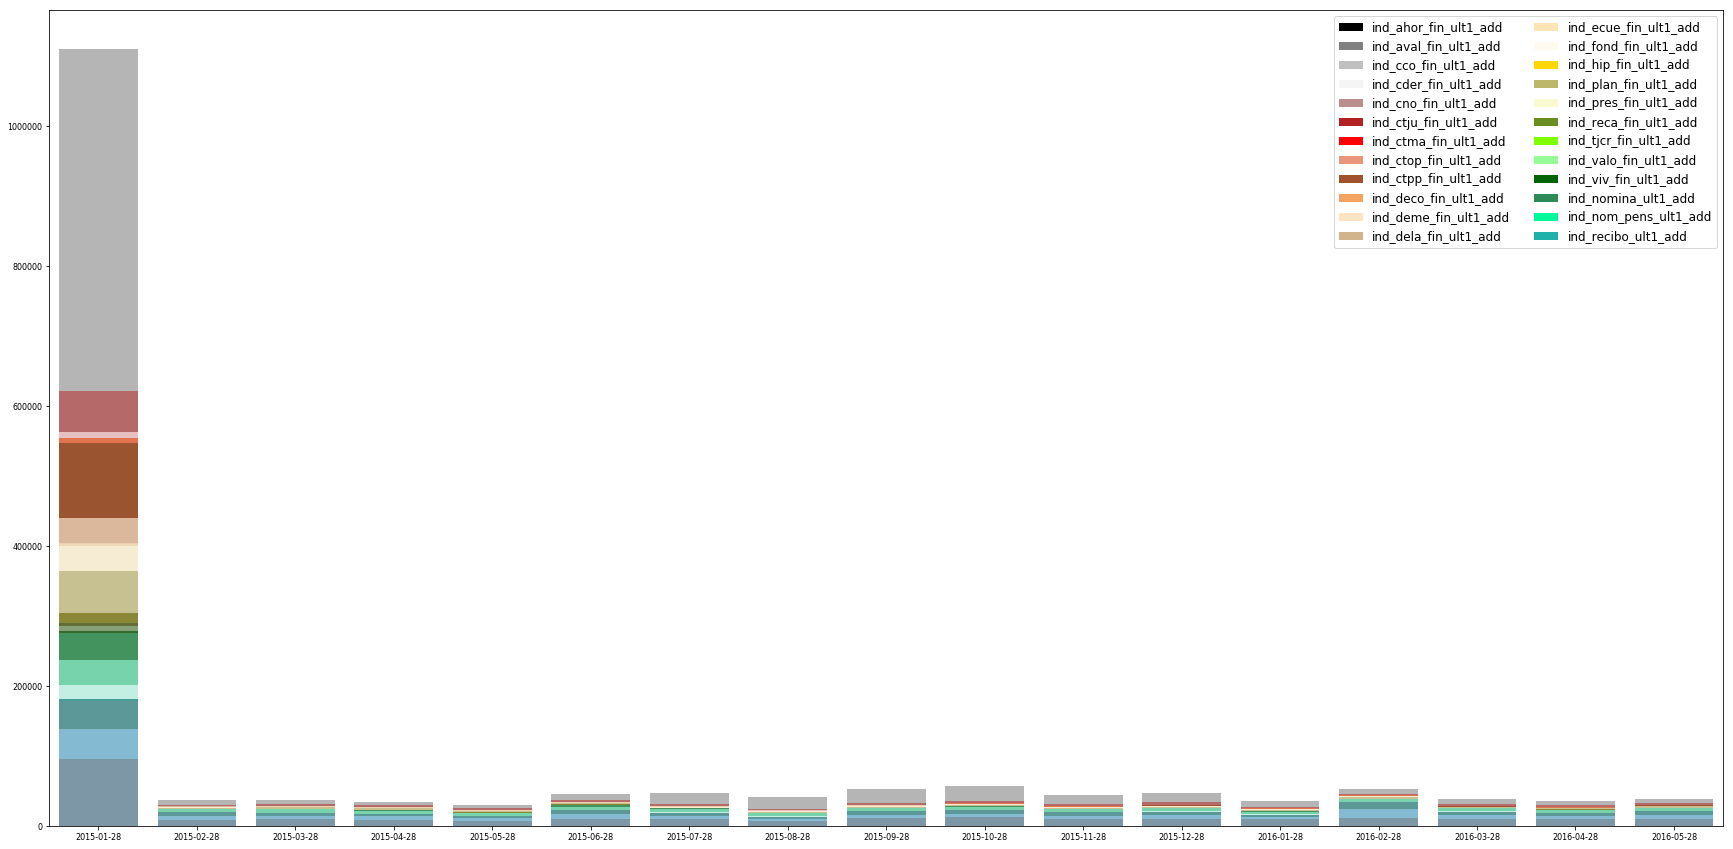

In [43]:
f, ax = plt.subplots(figsize=(30,15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_over_time[i], 
                color = colors_names[(i*5)%len(colors_names)], alpha=0.7)

    
plt.legend([plt.Rectangle((0,0), 1, 1, 
            fc=colors_names[(i*4)%len(colors_names)], edgecolor='none') 
                                for i in range(len(label_cols))],
            label_cols, loc=1, ncol=2, prop={'size':12})

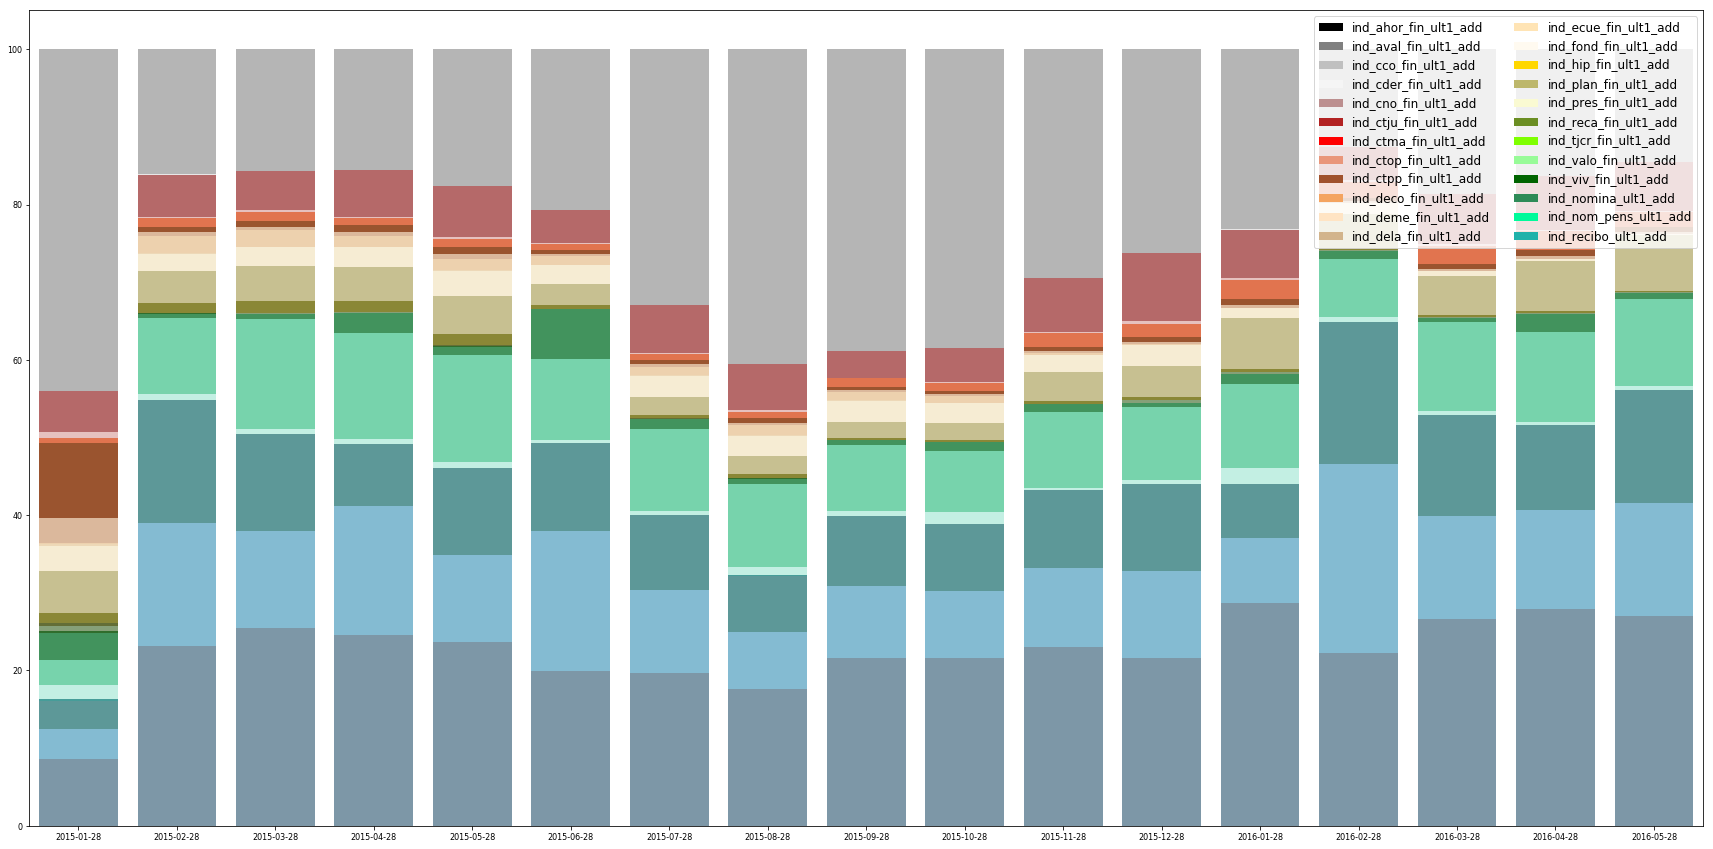

In [44]:
label_sum_percent = (label_sum_over_time / 
                    (1.*np.asarray(label_sum_over_time).max(axis=0)))*100
f, ax = plt.subplots(figsize=(30,15))
for i in range(len(label_cols)):
    sns.barplot(x=months, y=label_sum_percent[i],
                color=colors_names[(i*5)%len(colors_names)], alpha=0.7)
plt.legend([plt.Rectangle((0,0), 1, 1, 
                              fc=colors_names[(i*4)%len(colors_names)], 
                              edgecolor='none') 
                              for i in range(len(label_cols))],
                          label_cols, loc=1, ncol=2, prop={'size':12})